In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import efc_2dm_broad as efc
from wfsc import utils



INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
nlam = 3
wavelength_c = 825e-9*u.m
bw = 0.05
wavelengths = np.linspace(wavelength_c*(1-bw/2), wavelength_c*(1+bw/2), nlam)
wavelengths

<Quantity [8.04375e-07, 8.25000e-07, 8.45625e-07] m>

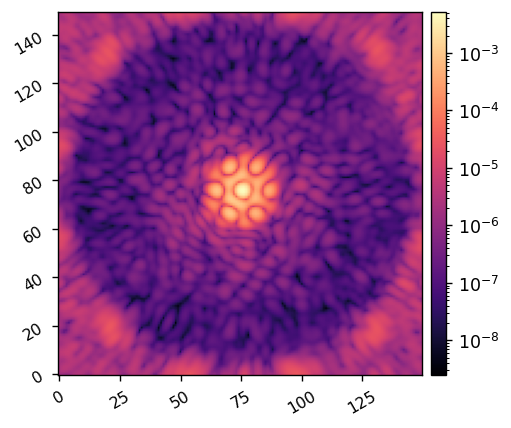

0.005216956582228274


In [3]:
reload(cgi)
sys_uo = cgi.CGI(cgi_mode='spc-wide', npsf=150,
              use_fpm=False,
              use_pupil_defocus=True, 
              polaxis=0,
              use_opds=True,
#               dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )

unocc_psf = 0
for wavelength in wavelengths:
    sys_uo.wavelength = wavelength
    unocc_psf += sys_uo.snap()/len(wavelengths)

misc.myimshow(unocc_psf, lognorm=True)
Imax_unocc = unocc_psf.max()
print(Imax_unocc)

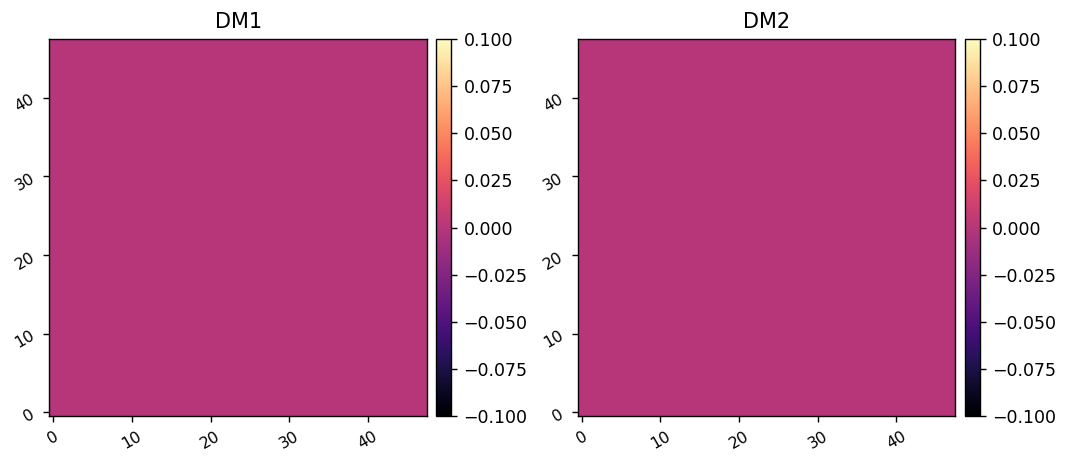

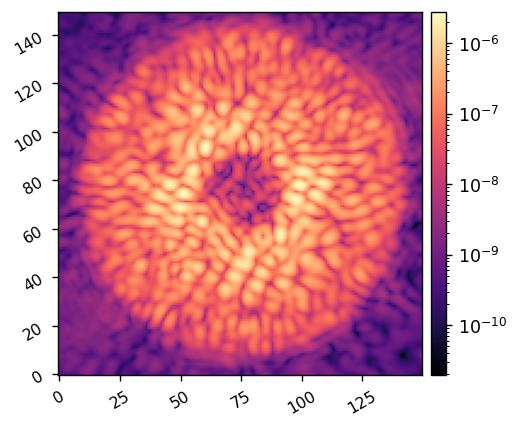

In [4]:
reload(cgi)
sys = cgi.CGI(cgi_mode='spc-wide', npsf=150,
              use_fpm=True,
              use_pupil_defocus=True, 
              polaxis=0,
              use_opds=True,
#               dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
sys.show_dms()

npsf = sys.npsf
Nact = sys.Nact

ref_psf = 0
for wavelength in wavelengths:
    sys.wavelength = wavelength
    ref_psf += sys.snap()/len(wavelengths)

misc.myimshow(ref_psf, lognorm=True)

# Create the dark-hole mask

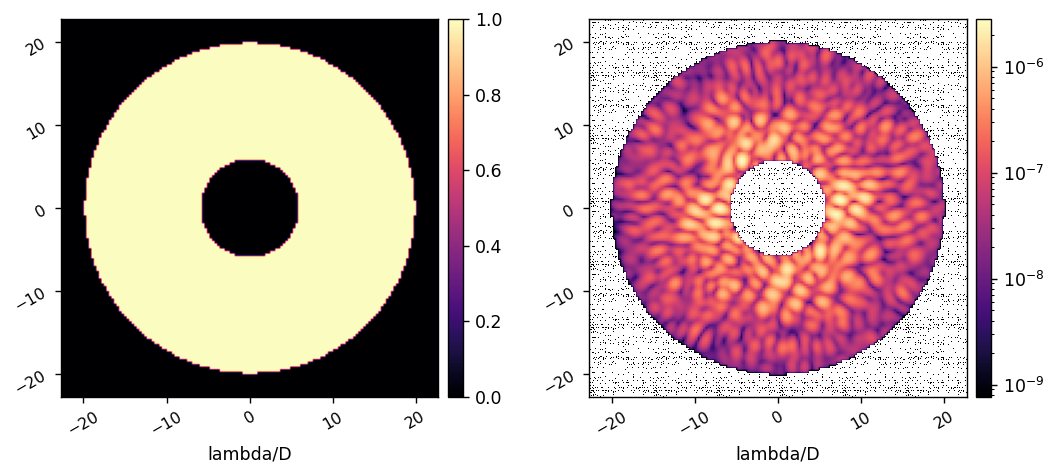

12328

In [5]:
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * sys.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 5.9
owa = 20
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
#     'direction' : '+x',
    'rotation':rot,
    'full':True
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params)

nmask = dh_mask.sum()

misc.myimshow2(dh_mask, ref_psf*dh_mask,  
               pxscl1=sys.psf_pixelscale_lamD, pxscl2=sys.psf_pixelscale_lamD,
               lognorm2=True)
nmask

In [12]:
# reload(efc)

# epsilon = 1e-9 # poke amplitudes (DM surface)
# jac = efc.build_jacobian(sys, wavelengths, epsilon, dh_mask.flatten(), display=False)

In [13]:
# jac_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/jacobians')
# fname = 'spc_wide_5.9to20_opds_2dm_broad'

# misc.save_pickle(jac_dir/fname, jac_new, quiet=False)

In [6]:
jac_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/jacobians')
fname = 'spc_wide_5.9to20_opds_2dm_broad'

jac = misc.load_pickle(jac_dir/fname)
jac.shape, jac[:,:Nact**2].shape, jac[:,Nact**2:].shape

((73968, 4608), (73968, 2304), (73968, 2304))

# Invert the Jacobian to get the control matrix

In [7]:
reload(utils)
reg_fun = utils.beta_reg
reg_conds = np.array([[0, 30, 45],
                      [-4, -5, -4]])
reg_conds = np.array([[0],
                      [-4]]) # beta=-4 is the same as 5e-3 for tikhonov

# Run EFC with perfect model

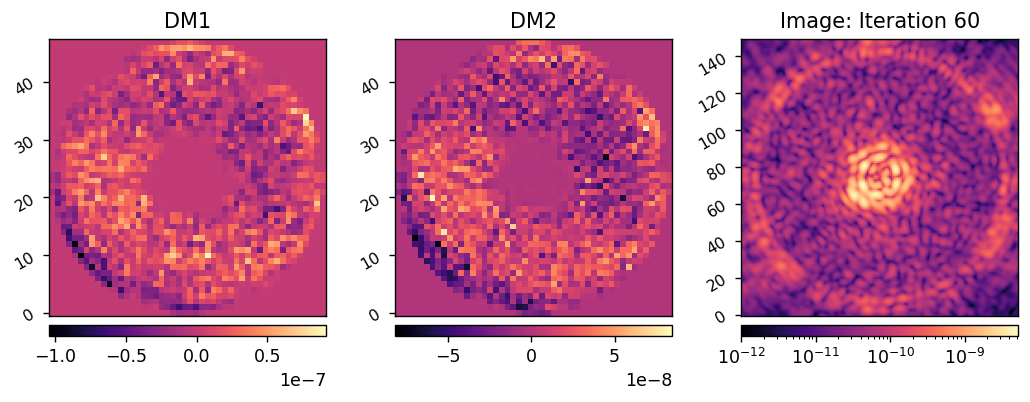

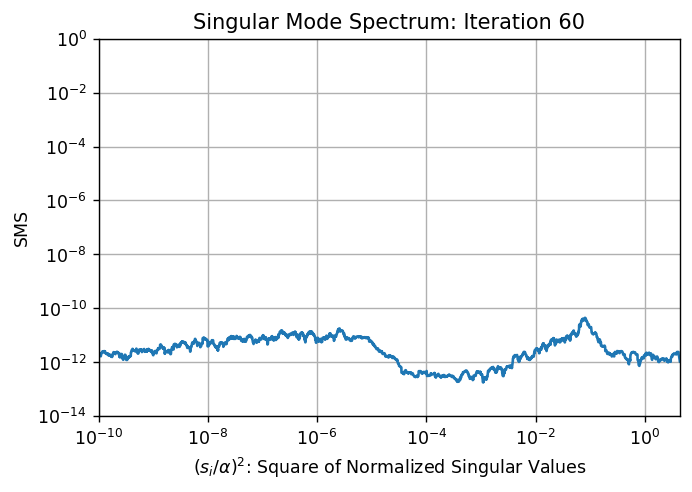

EFC completed in 150.277 sec.


In [11]:
reload(efc)
sys.reset_dms()
dm1_commands1, dm2_commands1, efields1 = efc.run_efc_perfect(sys, wavelengths, 
                                                             jac,
                                                             reg_fun,
                                                             reg_conds,
                                                             dh_mask, 
                                                             Imax_unocc,
                                                             iterations=60, 
                                                             display_current=True, 
                                                             plot_sms=True)

# Generate probes and test PWP
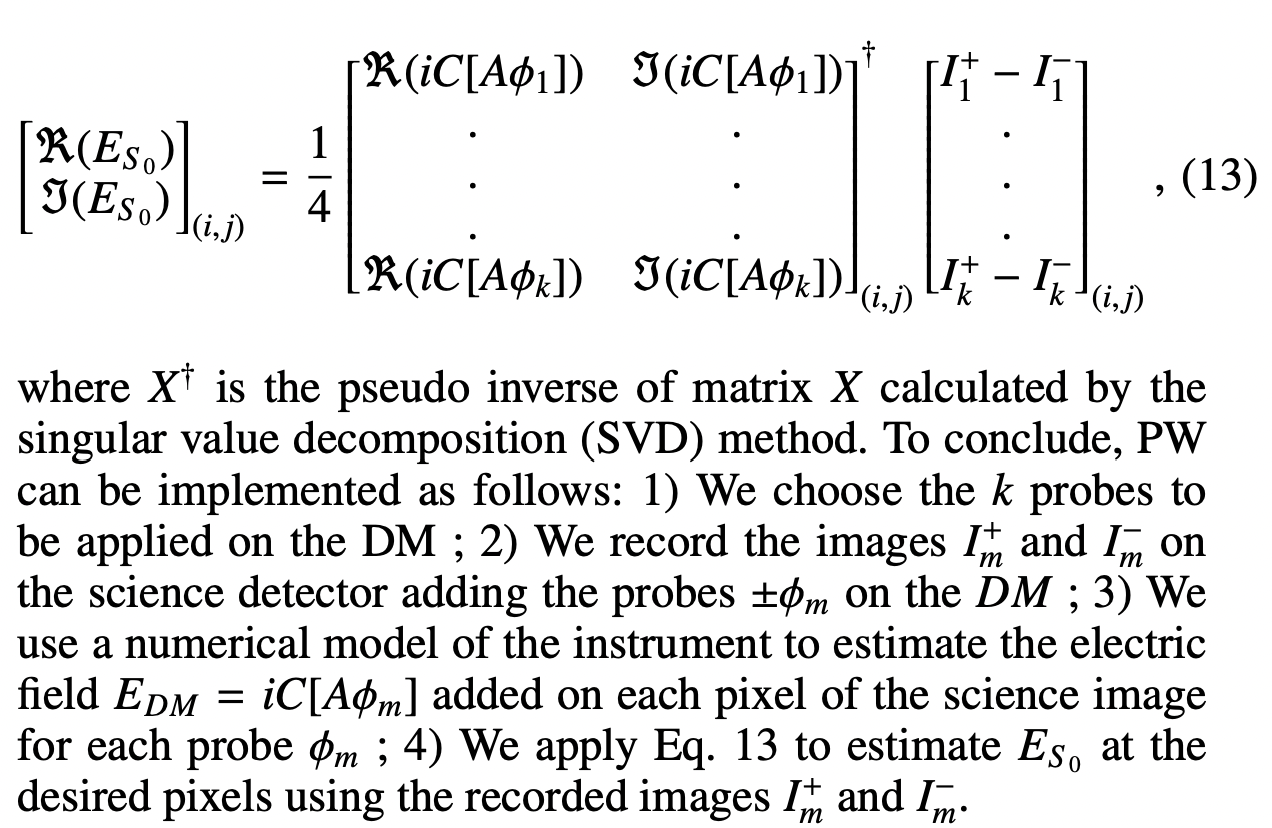

Generating probe with amplitude=2.063e-08, radius=12.0, phase=0.000, offset=(8.0,8.0), with discontinuity along x axis.
Generating probe with amplitude=2.063e-08, radius=12.0, phase=1.571, offset=(8.0,8.0), with discontinuity along y axis.


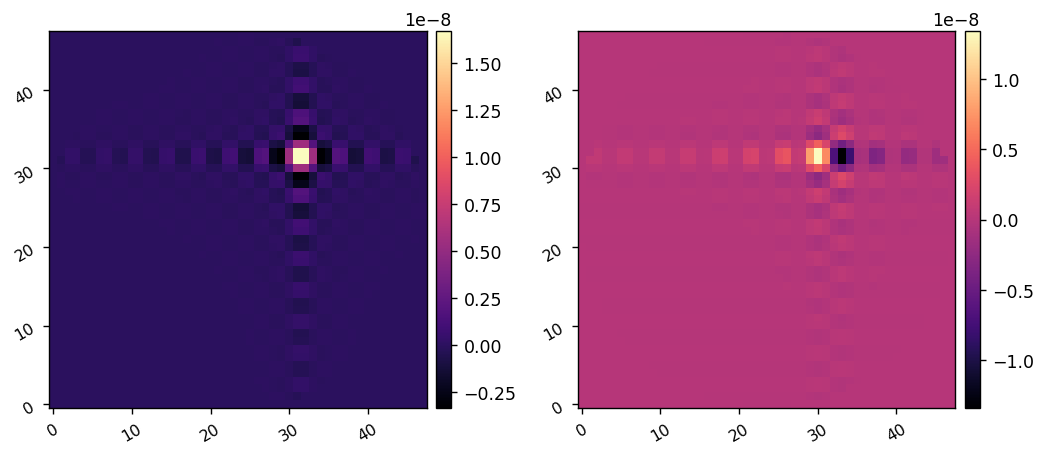

In [23]:
reload(efc)

Npairs = 2
probe_amp = 0.025*sys.wavelength_c.value
probe_radius = 12
probe_offset = (8,8)

probes = efc.create_sinc_probes(Npairs, Nact, sys.dm_mask, probe_amp, probe_radius, probe_offset, display=True)

In [ ]:
reload(efc)

sys.reset_dms()
E_est = efc.run_pwp(sys, probes, jac, dh_mask, reg_cond=1e-3, use_noise=False, display=True)
diff = abs(ref_psf*dh_mask - np.abs(E_est)**2)

vmin = 1e-12
vmax = ref_psf.max()
misc.myimshow3(np.abs(E_est)**2, 
               ref_psf*dh_mask, diff,
               'Estimated Intensity', 'Exact Intensity', 'Intensity Difference',
               lognorm1=True, lognorm2=True, lognorm3=True,
               vmin1=vmin, vmin2=vmin, vmin3=vmin,
               vmax1=vmax, vmax2=vmax, vmax3=vmax,
              )


np.mean(ref_psf[dh_mask]), np.mean(diff[dh_mask])

# Run EFC with PWP

In [39]:
reload(efc)
hlc.reset_dms()
commands2, efields2, images2 = efc.run_efc_pwp(sys, efc_matrix, jac, probes, dh_mask, iterations=10, display=False)

Beginning closed-loop EFC simulation.
	Running iteration 1/10.
	Running iteration 2/10.
	Running iteration 3/10.
	Running iteration 4/10.
	Running iteration 5/10.
	Running iteration 6/10.
	Running iteration 7/10.
	Running iteration 8/10.
	Running iteration 9/10.
	Running iteration 10/10.
EFC completed in 16.262 sec.
